In [1]:
%matplotlib inline
import cmlreaders as cml
import pybeh_pd as pb
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
all_fr1_events = cml.CMLReader.load_events(experiments=["FR1"])

In [3]:
events = all_fr1_events.query('type == ["WORD", "REC_WORD"]')
events.rename(columns={'item_name': 'item'}, inplace=True)
events = events[events['list'] > 0] # removing practice lists

#removing subjects who were presented with the same word multiple times (probably repeated data)
word_evs = events.query('type == "WORD"')
n_word_pres = word_evs.groupby(['subject', 'session', 'list', 'item_num']).size().to_frame(name='n').reset_index()
bad_lists = n_word_pres.query('n > 2')
bad_lists[['subject', 'session', 'list']].drop_duplicates()
bad_subs = bad_lists.subject.unique().tolist()
bad_subs = bad_subs + ["R1171M", "R1093J", "R1329T", "R1341T", "R1015J"] #"R1015J" had no recalls, other subjects unsure...
events.query('subject not in @bad_subs', inplace=True)

/home1/djhalp/.conda/envs/cml/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [4]:
pb_crp = events.groupby('subject').apply(pb.pd_crp, 
                                itemno_column='item_num').reset_index()

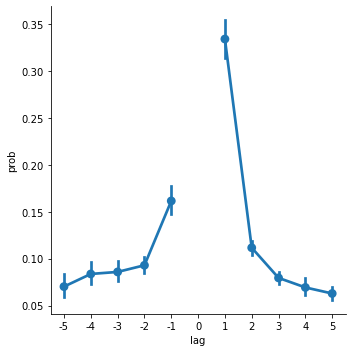

In [5]:
g = sns.catplot(x='lag', y='prob', kind='point', 
                  data=pb_crp.query('lag <= 5 and lag >= -5')
           )

In [6]:
pb_temp_fact = events.groupby("subject").apply(pb.pd_temp_fact,
                                                   itemno_column='item_num', 
                                                   list_index=['subject', 'session', 'list'], 
                                                   pres_type="WORD", rec_type="REC_WORD", type_column='type'
                                                   ).to_frame(name='temp_fact').reset_index()

pb_temp_fact

,subject,temp_fact
0,R1001P,0.625303
1,R1002P,0.602389
2,R1003P,0.697490
3,R1006P,0.674832
4,R1010J,0.603109
...,...,...
269,R1565T,0.926068
270,R1569T,0.758442
271,R1571T,0.741228
272,R1572T,0.395809


In [7]:
# replace item nums so they are consistent across subjects
item_col = 'item'
item_num_col = 'item_num'
item_num_df = events.query('type == "WORD"').drop_duplicates(subset=item_col, ignore_index=True
                                    )[item_col].reset_index().rename(columns={'index': item_num_col})
item_num_df['item_num'] = item_num_df['item_num'] + 1
events_new = events.merge(item_num_df, on=item_col, suffixes=('', '_new'), 
                          how='left', sort=False)#.sort_values('mstime')
events_new.fillna({'item_num_new': -999}, inplace=True)

In [8]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

In [9]:
def word_similarity(df, col1, col2, keyed_vector=None):
    try:
        return keyed_vector.similarity(df[col1].lower(), df[col2].lower())
    except:
        return np.nan

In [10]:
# get all pairs of items
items = item_num_df.item.values
sem_sim_df = pd.MultiIndex.from_product([items, items], names=['item_1', 'item_2']).to_frame(index=False)

In [11]:
sem_sim_df

,item_1,item_2
0,HOUSE,HOUSE
1,HOUSE,HAWK
2,HOUSE,WAND
3,HOUSE,GEESE
4,HOUSE,STAR
...,...,...
563996,VIGA,PECHO
563997,VIGA,CAMELLO
563998,VIGA,INUNDACION
563999,VIGA,BEBE


In [12]:
# compute similarity of all pairs
sem_sim_df['similarity'] = sem_sim_df.apply(word_similarity, 
               axis=1, col1='item_1', 
               col2='item_2', 
               keyed_vector=word2vec_vectors)

In [13]:
sem_sim_num_df = sem_sim_df.merge(
    item_num_df, left_on='item_1', right_on='item').merge(
    item_num_df, left_on='item_2', right_on='item', suffixes=('_1', '_2')).drop(columns=['item_1', 'item_2'])

/home1/djhalp/.conda/envs/cml/lib/python3.7/site-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'item_1'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


In [14]:
sem_sims = pd.pivot_table(sem_sim_num_df, index='item_num_1', columns='item_num_2', values='similarity', dropna=False)

In [15]:
events_new.query('item_num_new == -999')

,answer,eegfile,eegoffset,exp_version,experiment,intrusion,is_stim,iscorrect,item,item_num,...,rectime,rejected,serialpos,session,stim_list,stim_params,subject,test,type,item_num_new
41,-999,R1001P_FR1_0_12Oct14_1034,519766,1.02,FR1,-1,0,-999,GOD,-1,...,3226,NaN,-999,0,0,[],R1001P,"[0, 0, 0]",REC_WORD,-999.0
47,-999,R1001P_FR1_0_12Oct14_1034,530085,1.02,FR1,-1,0,-999,CLOVE,-1,...,23865,NaN,-999,0,0,[],R1001P,"[0, 0, 0]",REC_WORD,-999.0
62,-999,R1001P_FR1_0_12Oct14_1034,573878,1.02,FR1,-1,0,-999,CLOTHES,-1,...,9706,NaN,-999,0,0,[],R1001P,"[0, 0, 0]",REC_WORD,-999.0
65,-999,R1001P_FR1_0_12Oct14_1034,582397,1.02,FR1,-1,0,-999,SHAKE,-1,...,26744,NaN,-999,0,0,[],R1001P,"[0, 0, 0]",REC_WORD,-999.0
135,-999,R1001P_FR1_0_12Oct14_1034,972785,1.02,FR1,-1,0,-999,SET,-1,...,3513,NaN,-999,0,0,[],R1001P,"[0, 0, 0]",REC_WORD,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176761,-999,R1571T_FR1_0_29Jul21_1453,1223776,1.05,FR1,-1,0,-999,MOOD,-1,...,2864,-999.0,-999,0,0,[],R1571T,"[0, 0, 0]",REC_WORD,-999.0
176763,-999,R1571T_FR1_0_29Jul21_1453,1229974,1.05,FR1,-1,0,-999,PLACE,-1,...,9062,-999.0,-999,0,0,[],R1571T,"[0, 0, 0]",REC_WORD,-999.0
176776,-999,R1571T_FR1_0_29Jul21_1453,1327076,1.05,FR1,-1,0,-999,BRACE,-1,...,7804,-999.0,-999,0,0,[],R1571T,"[0, 0, 0]",REC_WORD,-999.0
176810,-999,R1571T_FR1_0_29Jul21_1453,1606840,1.05,FR1,-1,0,-999,WEEK,-1,...,6098,-999.0,-999,0,0,[],R1571T,"[0, 0, 0]",REC_WORD,-999.0


In [16]:
pb_sem_crp = events_new.groupby('subject').apply(pb.pd_sem_crp, 
                                itemno_column='item_num_new', sem_sims=sem_sims).reset_index()

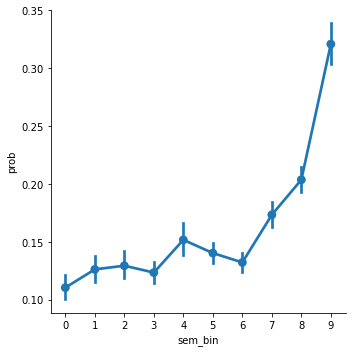

In [17]:
g = sns.catplot(x='sem_bin', y='prob', kind='point', 
                  data=pb_sem_crp
           )

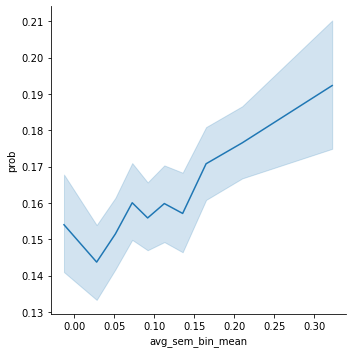

In [19]:
#using average bin value
pb_sem_crp['avg_sem_bin_mean'] = pb_sem_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
g = sns.relplot(x='avg_sem_bin_mean', y='prob', data=pb_sem_crp, kind='line')

In [18]:
pb_sem_dist_fact = events_new.groupby("subject").apply(pb.pd_dist_fact,
                                                       rec_itemnos=None, 
                                                       itemno_column='item_num_new', 
                                                       list_index=['subject', 'session', 'list'], 
                                                       dist_mat=sem_sims, 
                                                       sim_columns=None, 
                                                       is_similarity=True, 
                                                       dist_columns=None,
                                                       skip_first_n=0,
                                                       pres_type="WORD", rec_type="REC_WORD", type_column='type', ret_counts=False
                                                       ).to_frame(name='sem_fact').reset_index()

pb_sem_dist_fact

,subject,sem_fact
0,R1001P,0.550296
1,R1002P,0.548142
2,R1003P,0.545138
3,R1006P,0.550895
4,R1010J,0.650000
...,...,...
269,R1565T,0.603144
270,R1569T,0.579774
271,R1571T,0.640936
272,R1572T,0.651736
